# 共享自行车使用量预测

## 背景信息


自行车共享系统是一种新型的自行车租赁服务，从加入会员到租赁再到还回自行车的整个过程都是自动化的。用户可以通过这些系统轻松地从某个位置租赁自行车并在另一个位置还回自行车。目前，全球有超过 500 个自行车共享项目，并投入了超过 500 万辆自行车。如今，这类系统更是受到大量关注，因为它们可以缓解交通、环境和健康问题。

除了自行车共享系统在现实生活中的有趣应用之外，这些系统生成的数据也具有独特的特性，吸引了人们去关注研究。与其他交通服务（例如公交或地铁）不同，这些系统会明确地记录行程时长、出发地点和抵达地点。这一特征使得自行车共享系统成为虚拟传感器网络，可以用来移动的感知一座城市的状况。因此，我们通过监控这些数据，一般都能检测到城市的大部分重大事件。

## 数据集

自行车共享租赁行为与环境和季节之间的关联性很大。例如，天气条件、降水情况、周几、季节、一天的时刻等都会影响到租赁行为。核心数据集采用的是美国华盛顿特区 Capital Bikeshare 系统 2011 至 2012 年的两年间历史记录日志，该数据集可以被公开访问 (http://capitalbikeshare.com/system-data )。我们按照 2 小时间隔和每日间隔汇总了数据，然后提取并添加了相应的天气和季节性信息。天气信息来自 http://www.freemeteo.com。
	- Readme.txt - 包含了数据集中各个字段的说明
	- hour.csv - 按照每小时汇总的共享自行车使用人数。
	- day.csv - 按照每天汇总的共享自行车使用人数。

## 任务
预测基于环境和季节性信息的每时或每日自行车租赁人数。

----
## 加载数据
运行下面的代码单元以载入需要的Python库并导入数据。

In [1]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score
import timeit

# 为notebook提供更加漂亮的可视化
%matplotlib inline

# TODO：导入数据
%cd F:\\Python\\test
dayDF=pd.read_csv('day.csv',index_col=0)
hourDF=pd.read_csv('hour.csv',index_col=0)
# TODO：显示第一条记录
print('原始数据放在F:\\Python\\test中')

F:\Python\test
原始数据放在F:\Python\test中


## 数据探索
首先我们对数据集进行一个粗略的探索，比如：总的记录数量；将cnt列（骑车用户数汇总列）按照日期分布进行绘图等等，尽情发挥你的想象，可以从多维度探索数据。

### TODO：总的记录数

In [2]:
# TODO：总的记录数
n_DSample,n_DFeature=dayDF.shape
n_HSample,n_HFeature=hourDF.shape
last_DSample_ind=dayDF.index[-1]
last_HSample_ind=hourDF.index[-1]
print('Day文件中总记录数量为{0},缺失记录数量为{1}，总特征数量为{2}'.format(n_DSample,last_DSample_ind-n_DSample,n_DFeature))
print('hour文件中总记录数量为{0},缺失记录数量为{1}，总特征数量为{2}'.format(n_HSample,last_HSample_ind-n_HSample,n_HFeature))


Day文件中总记录数量为731,缺失记录数量为0，总特征数量为15
hour文件中总记录数量为17379,缺失记录数量为0，总特征数量为16


以下仅对每日自行车租赁人数进行了分析，未对每时自行车租赁人数进行分析。

### TODO：将cnt列（骑车用户数汇总列）按照日期分布进行绘图


#### 骑车用户数随日期变化趋势

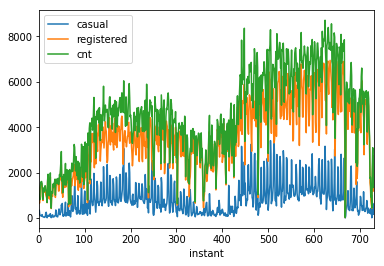

In [3]:
#骑车用户数随日期变化趋势
dayDF.plot(y=['casual','registered','cnt'])

由上图可以看出，第2年的用户数明显比第一年的用户数多。在一年中，存在一个随季节变化的大的包络，在这个低频变化的基础上，叠加了高频变化，使得曲线有较大抖动。

#### 按各时期查看日平均自行车使用人数

In [4]:
#定义函数，按各时期查看日平均自行车使用人数，以便批量定制图设置
def cnt_time_plt(time,yticklabels,ylabel):
    axes=sns.barplot(x='cnt',y=time,data=dayDF,orient='h')
    axes.set_yticklabels(yticklabels)
    axes.set_ylabel(ylabel)
    axes.set_xlabel('day average cnt') 

##### 按年查看日平均自行车使用人数

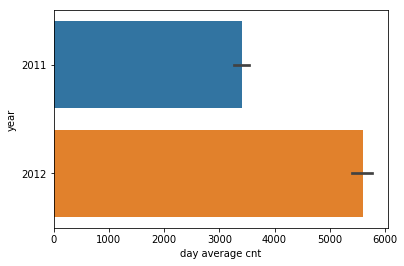

In [5]:
cnt_time_plt(time='yr',yticklabels=['2011','2012'],ylabel='year')

##### 按季度查看自行车使用人数

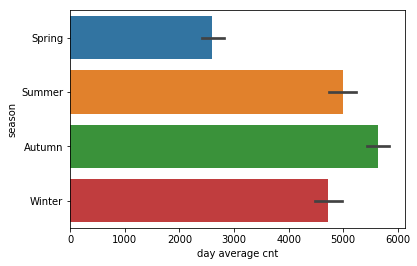

In [6]:
cnt_time_plt(time='season',yticklabels=['Spring','Summer','Autumn','Winter'],ylabel='season')

##### 按月查看日平均自行车使用人数

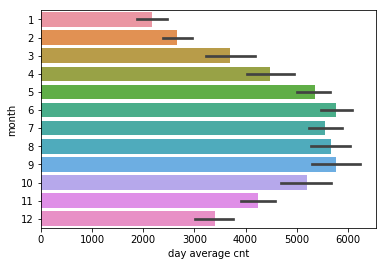

In [7]:
cnt_time_plt(time='mnth',yticklabels=range(1,13),ylabel='month')

##### 按星期查看日平均自行车使用人数

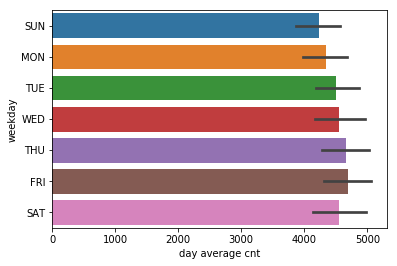

In [8]:
cnt_time_plt(time='weekday',yticklabels=['SUN','MON','TUE','WED','THU','FRI','SAT'],ylabel='weekday')

##### 按工作日查看日平均自行车使用人数

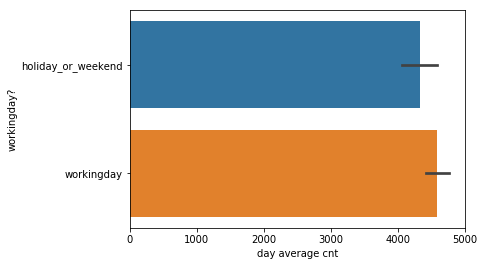

In [9]:
cnt_time_plt(time='workingday',yticklabels=['holiday_or_weekend','workingday'],ylabel='workingday?')

##### 按假期查看日平均自行车使用人数

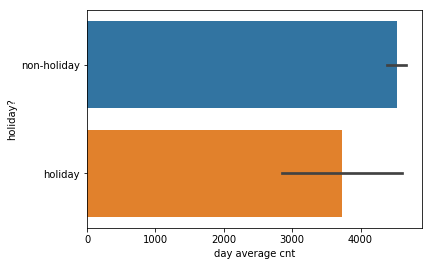

In [10]:
cnt_time_plt(time='holiday',yticklabels=['non-holiday','holiday'],ylabel='holiday?')

从以上图可以看出，日平均自行车使用人数随月份和季节的变化表现出明显的非线性变化，其余特征非线性效应不明显。

### 骑车用户数与天气特征之间的关系


#### 天气与骑车用户数关系


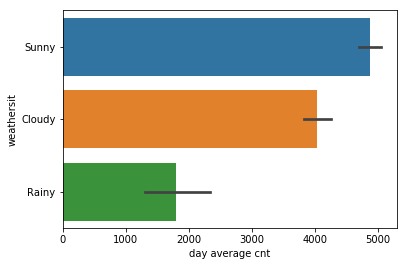

In [11]:
cnt_time_plt(time='weathersit',yticklabels=['Sunny','Cloudy','Rainy','Snowing'],ylabel='weathersit')

#### 天气具体指标与骑车用户数关系

In [12]:
#定义函数，绘出环境条件与总骑车用户数的关系，以便批量定制图设置
def cnt_condition_scatter(condition,xlabel):
    axes=sns.regplot(x=condition,y='cnt',data=dayDF)
    axes.set_xlabel(xlabel)
    axes.set_ylabel('day average cnt') 

##### 温度与骑车用户数关系


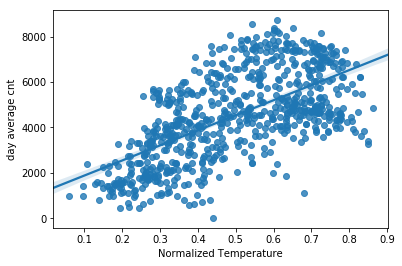

In [13]:
cnt_condition_scatter('temp','Normalized Temperature')

##### 体感温度与骑车用户数关系


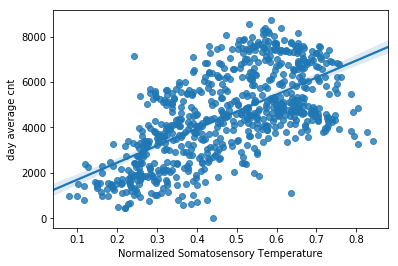

In [14]:
cnt_condition_scatter('atemp','Normalized Somatosensory Temperature')

##### 湿度与骑车用户数关系


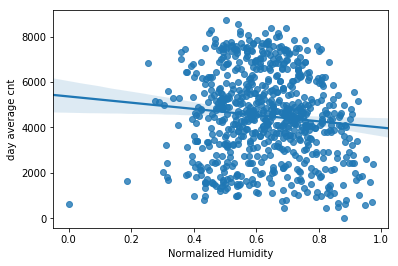

In [15]:
cnt_condition_scatter('hum','Normalized Humidity')

##### 风力与骑车用户数关系


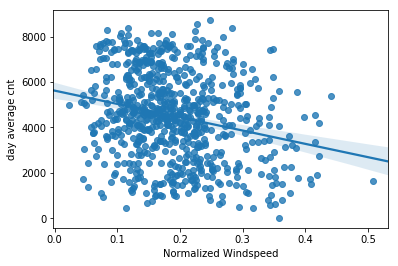

In [16]:
cnt_condition_scatter('windspeed','Normalized Windspeed')

从以上图可以看出，日平均自行车使用人数与温度正相关，与湿度、风力负相关，符合日常预期。

----
## 数据处理
在数据能够被作为输入提供给机器学习算法之前，它经常需要被清洗，格式化，和重新组织 - 这通常被叫做**预处理**。幸运的是，对于这个数据集，没有我们必须处理的无效或丢失的条目，然而，由于某一些特征存在的特性我们必须进行一定的调整。这个预处理都可以极大地帮助我们提升几乎所有的学习算法的结果和预测能力。

### 标准化数字特征
除了对于高度倾斜的特征施加转换，对数值特征施加一些形式的缩放通常会是一个好的习惯。在数据上面施加一个缩放并不会改变数据分布的形式（比如上面说的'capital-gain' or 'capital-loss'）；但是，归一化保证了每一个特征在使用监督学习器的时候能够被平等的对待。注意一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了。
请考虑是否需要归一化或者标准化（连续性数值标量）

在此，我将舍弃dteday一列的数据，因为其可由其他时间特征推断出。对于其他特征，对他们进行标准化：由于温度、湿度、风力等已经是标准化后的数据了，我们对其他特征做标准化，标准化的方法仍采用原始值除以该特征的最大值。

In [17]:
# 数据归一化，并去掉'dteday'列
dayDF_Norm=dayDF.copy()
dayDF_Norm.loc[:,'season':'weathersit']=dayDF_Norm.loc[:,'season':'weathersit']/dayDF_Norm.loc[:,'season':'weathersit'].max(0)
del(dayDF_Norm['dteday'])

----
## 特征工程

###  观察特征相关性，提取特征重要性

当**探索数据**的时候，你认为哪些特征对于预测是最重要的，你会怎样对他们排序？理由是什么？_

当**探索数据**的时候，我对特征重要性的排序为：温度、体感温度、年份、天气（weathersit）、季度、月份、风力、湿度、其他特征。

理由为：

对于自变量离散的特征，用的是条形图展示，纵轴是不同的特征，横轴是日平均骑车用户量，误差条是均值置信区间95%的范围。一方面，不同特征的日平均骑车用户量差异越大，则该特征的影响越显著；另一方面误差条越窄，该特征的影响越确定。因而二者之比可以表现影响的大小。观察后可以粗略判断离散自变量重要性排序为：年份、天气（weathersit）、季度、月份、其他特征。

对于自变量连续的特征，用的是散点图展示，并用直线对其拟合，（由于数据已经归一化）斜率的绝对值越大，说明该特征的影响越显著；点与直线的离散程度越小，该特征的影响越确定。因而二者之比可以表现影响的大小。观察后可以粗略判断离散自变量重要性排序为：温度、体感温度、风力、湿度。

对于以上两种不同离散情况的数据对比，主要是从散点图的点与直线的离散程度从直觉上判断的。

以下将给出定量的判断。

#### 相关系数分析

In [18]:
# TODO 特征相关性及重要性排序，提取特征重要性
day_corr=dayDF_Norm.corr()
# 下表给出了各特征与目标之间的相关系数矩阵
day_corr
# sns.pairplot(dayDF_Norm, diag_kind='kde', plot_kws={'alpha': 0.2})

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.210399,0.411623,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,0.248546,0.594248,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,0.123006,0.293488,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.054274,-0.108745,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.059923,0.057367,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.518044,0.303907,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.247353,-0.260388,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,0.543285,0.540012,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,0.543864,0.544192,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.077008,-0.091089,-0.100659


从中可以看出，与总骑车用户数相关性由大到小排名为：体感温度（atemp，0.631），温度（temp，0.627），年份（yr，0.567），季节（season，0.406），天气（weathersit，-0.297），月份（mnth，0.280），风力（windspeed，-0.235），湿度（-0.101），假期、星期信息等(0.06左右）。

和总骑车用户相比，与注册用户数相关性与之最大的差异在于，注册用户数与工作日（workingday）的相关性明显提升（从0.06升到0.30），可见注册用户骑车更多用于工作通勤。

对于各特征与临时用户的相关性，工作日（workingday）成了负相关，且相关性较大（-0.52），这说明临时用户骑车更多用于业余出行，如外出游玩等。
工作日特征对注册用户与临时用户有相反的影响，对于总用户数，二者恰好相互抵消，最终造成总用户数与工作日特征相关性不大。

下面用sk-learn包给出特征重要性评价。

#### F值打分法

In [19]:
X0, y0 = dayDF_Norm.loc[:,'season':'windspeed'], dayDF_Norm['cnt']
# X_new = SelectKBest(f_regression, k='all').fit_transform(X0, y0)
scores_ ,pvalues_ = f_regression(X0,y0)
X_new = SelectPercentile(f_regression, 50).fit_transform(X0, y0)
print('前50%重要的特征为\n',X_new)
print('每种特征的重要性分数为\n',scores_)
X0

前50%重要的特征为
 [[ 0.25        0.          0.66666667  0.344167    0.363625  ]
 [ 0.25        0.          0.66666667  0.363478    0.353739  ]
 [ 0.25        0.          0.33333333  0.196364    0.189405  ]
 ..., 
 [ 0.25        1.          0.66666667  0.253333    0.2424    ]
 [ 0.25        1.          0.33333333  0.255833    0.2317    ]
 [ 0.25        1.          0.66666667  0.215833    0.223487  ]]
每种特征的重要性分数为
 [ 143.96765259  344.89058554   62.00462455    3.42144104    3.33109137
    2.73674228   70.72929783  473.47171053  482.45431053    7.46194
   42.43784159]


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
instant,,,,,,,,,,,
1,0.25,0.0,0.083333,0.0,1.000000,0.0,0.666667,0.344167,0.363625,0.805833,0.160446
2,0.25,0.0,0.083333,0.0,0.000000,0.0,0.666667,0.363478,0.353739,0.696087,0.248539
3,0.25,0.0,0.083333,0.0,0.166667,1.0,0.333333,0.196364,0.189405,0.437273,0.248309
4,0.25,0.0,0.083333,0.0,0.333333,1.0,0.333333,0.200000,0.212122,0.590435,0.160296
5,0.25,0.0,0.083333,0.0,0.500000,1.0,0.333333,0.226957,0.229270,0.436957,0.186900
6,0.25,0.0,0.083333,0.0,0.666667,1.0,0.333333,0.204348,0.233209,0.518261,0.089565
7,0.25,0.0,0.083333,0.0,0.833333,1.0,0.666667,0.196522,0.208839,0.498696,0.168726
8,0.25,0.0,0.083333,0.0,1.000000,0.0,0.666667,0.165000,0.162254,0.535833,0.266804
9,0.25,0.0,0.083333,0.0,0.000000,0.0,0.333333,0.138333,0.116175,0.434167,0.361950


由上表可以看出，用F值的打分方法，特征重要性排序为：体感温度（482）>温度（473）>年份（345）>季节（144）>天气（71）>月份（62）>风力（42）>湿度（7.5）>其他（小于4），与相关系数排序相同。

前50%分位数的重要特征为：体感温度，温度，年份，季节与天气。

重要性总分数为1637，体感温度与温度两个特征已经贡献了数据中所有特征中超过一半的重要性。然而，很明显，这两个特征高度相关（相关系数0.99）。

#### 互信息值打分法

In [20]:
# X_new = SelectKBest(f_regression, k='all').fit_transform(X, y)
mi = mutual_info_regression(X0,y0)
X_new2 = SelectPercentile(mutual_info_regression, 50).fit_transform(X0, y0)
print('前50%重要的特征为\n',X_new)
print('每种特征的重要性分数为\n',mi)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


前50%重要的特征为
 [[ 0.25        0.          0.66666667  0.344167    0.363625  ]
 [ 0.25        0.          0.66666667  0.363478    0.353739  ]
 [ 0.25        0.          0.33333333  0.196364    0.189405  ]
 ..., 
 [ 0.25        1.          0.66666667  0.253333    0.2424    ]
 [ 0.25        1.          0.33333333  0.255833    0.2317    ]
 [ 0.25        1.          0.66666667  0.215833    0.223487  ]]
每种特征的重要性分数为
 [ 0.21541127  0.27983803  0.37556263  0.01100599  0.04496246  0.02494266
  0.06881579  0.388678    0.46491113  0.04640637  0.05551423]


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


由上表可以看出，用互信息的打分方法，特征重要性排序为：体感温度（0.465）>温度（0.390）>月份（0.377）>年份（0.279）>季节（0.214）>天气（0.069）>风力（0.056）>湿度（0.046）>其他（小于0.046），除月份特征排名有所提前外，其余与F值排序相同。

前50%分位数的重要特征为：体感温度，温度，月份，年份与季节。

重要性总分数为1.97，体感温度、温度与月份3个特征已经贡献了数据中所有特征中超过一半的重要性。

至此，我分析了各特征的重要性，但某些特征之间存在着强相关性，仍然不适合直接采用以上排名中前几个特征。下面我将结合特定的模型，再讨论特征选择问题。

## 模型尝试与相应特征选取

对于你选择的每一个算法：

- *描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）*
- *这个模型的优势是什么？他什么情况下表现最好？*
- *这个模型的缺点是什么？什么条件下它表现很差？*
- *根据我们当前数据集的特点，为什么这个模型适合这个问题。*

针对该问题，我想到了3个模型，每个模型有不同的特征选取方式，说明如下：

### 多元线性回归

#### 应用场景

一个典型的例子是波士顿房价问题，影响一个房价的因素可能有很多，比如住房面积、卧室数目等，通过多元线性回归，可以对房价进行预测。可参考论文：’Hedonic prices and the demand for clean air’, J. Environ. Economics & Management, vol.5, 81-102, 1978

#### 优势与使用条件

优势在于算法简单，无需调参。满足以下条件时表现最好（参考资料：《SPSS统计分析高级教程》）
1. 自变量与因变量之间存在线性关系
2. 各观测间相互独立
3. 残差e 服从正态分布N(0,σ2) 
4. e的大小不随所有变量取值水平的改变而改变，即方差齐性

#### 缺点与不适合条件

缺点在于使用条件较为苛刻，若在实际问题中，自变量与因变量之间存在严重的非线性关系，或自变量间相关性很强，则效果不好。

#### 模型适合本问题的原因

若直接采用所有特征，则存在两个问题，其一在于月份（或季节）与用户量之间明显存在非线性关系，其二则是体感温度与温度之间存在强相关关系。因而我将把月份（及季节）与温度两个特征直接去掉，这样便基本符合使用条件。

### 多项式回归

#### 应用场景

当自变量与因变量之间存在非线性关系时，会考虑多项式回归。如在非线性光学中，当入射光较强时，材料的极化率与光强会呈现非线性关系。参考百度百科https://baike.baidu.com/item/%E9%9D%9E%E7%BA%BF%E6%80%A7%E5%85%89%E5%AD%A6 

#### 优势与使用条件

优势在于可以较好解决部分自变量与因变量之间存在非线性关系的问题。当问题涉及的次数恰好与多项式的系数相同时，表现较好。

#### 缺点与不适合条件

缺点包括以下几点：
1. 并非所有非线性关系都能用多项式回归解决，可能用在错误场景中。
2. 多项式的系数不确定，需要调参。
3. 模型复杂度有所提升。

#### 模型适合本问题的原因

在数据探索模块中，可以发现月份（或季节）与用户量之间的关系基本上可以用2次函数拟合，其余特征的非线性不强，因而最多用2次即可。由于涉及的次数较为确定，因而预测会有较好的效果。另外由于从月份特征中可直接推断季节特征，体感温度与温度具有强相关性，我将在模型中直接去除季节特征与温度特征。

### 支持向量回归

#### 应用场景与模型适合本问题的原因

通过核方法可将线性学习器拓展为非线性学习器，这里可以做些尝试。

#### 特征选择

与多项式回归相同，我将在模型中直接去除季节特征与温度特征。

----
## 模型评估
模型评估的指标有哪些？
你选择了什么指标来评估你的模型？选择指标的理由是什么？

对于回归问题，常用的评估指标有：解释方差得分（explained variance score）、平均绝对误差（mean absolute error）、均方误差（mean squared error）、均方误差对数（mean squared log error）、中位绝对误差（median absolute error）、可决系数（R^2 score）等。在sk-learn中一般默认用可决系数（R^2 score），因而这里也采取该指标。

在确定评估指标之后，为了减弱欠拟合和过拟合的问题，一般需要用交叉验证法。

----
## 选择最佳的模型

基于你前面做的评价，用一到两段解释这三个模型中哪一个针对于这个预测问题是最合适的。             
**提示：**你的答案应该包括关于评价指标，预测/训练时间，以及该算法是否适合这里的数据的讨论。所选模型的主要特点。例如，这个模型是怎样被训练的，它又是如何做出预测的。避免使用高级的数学或技术术语，不要使用公式或特定的算法名词。

由于问题本身具有非线性，只有将月份特征删除后，才基本可用线性回归或主成分回归来预测，但这样做丢失了较大的信息量，预计这两种模型都不如多项式回归准确。多项式回归与支持向量回归的比较相对困难，下面在未仔细调参的情况下做一次3折交叉验证，初步比较二者对所有数据拟合后的得分，选择得分高的一种。

### 多元线性回归

将多元线性回归作为一个基准。

In [23]:
# 对于多元线性回归，去除季节、月份、温度3个特征
X=X0.copy()
y=y0.copy()
del(X['season'])
del(X['mnth'])
del(X['temp'])
X=X.values
y=y.values

In [24]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=3)
print('3折分数分别为：',scores)
print('平均分数：',np.mean(scores))

3折分数分别为： [ 0.40848927  0.4604327   0.34712742]
平均分数： 0.405349794193


In [26]:
# 若不去除月份特征，做一个对比
X=X0.copy()
y=y0.copy()
del(X['season'])
del(X['temp'])
X=X.values
y=y.values

In [27]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=3)
print('3折分数分别为：',scores)
print('平均分数：',np.mean(scores))

3折分数分别为： [ 0.61072487  0.57947497  0.45664407]
平均分数： 0.548947967684


In [28]:
# 若再添加季节特征，做一个对比
X=X0.copy()
y=y0.copy()
del(X['temp'])
X=X.values
y=y.values

In [29]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=3)
print('3折分数分别为：',scores)
print('平均分数：',np.mean(scores))

3折分数分别为： [ 0.64622911  0.62868551  0.52629189]
平均分数： 0.600402170554


In [30]:
# 对于后两种模型，去除季节和温度两个特征
X=X0.copy()
y=y0.copy()
del(X['season'])
del(X['temp'])
X=X.values
y=y.values

### 多项式回归

In [33]:
# 直接2次多项式回归
model = Pipeline([('poly', PolynomialFeatures(2)),
                    ('linear', LinearRegression())])
scores = cross_val_score(model, X, y, cv=3)
print('3折分数分别为：',scores)
print('平均分数：',np.mean(scores))

3折分数分别为： [ 0.19487561 -0.14038682  0.34256579]
平均分数： 0.132351526386


In [34]:
# 月份特征用2次项，其他特征用1次项
def Add_X_1_Square(X):
    X_1_Square=X[:,1]**2
    X_1_Square=np.reshape(X_1_Square,(len(X_1_Square),1))
    return np.hstack((X,X_1_Square))

model = Pipeline([('poly', FunctionTransformer(Add_X_1_Square)),
                  ('linear', LinearRegression())])
scores = cross_val_score(model, X, y, cv=3)
print('3折分数分别为：',scores)
print('平均分数：',np.mean(scores))

3折分数分别为： [ 0.65922653  0.62992745  0.49822851]
平均分数： 0.595794163016


In [37]:
# 月份特征用周期为1年的三角函数项，其他特征用1次项
def sin_month(X):
    X_1_sin=np.sin(X[:,1]*2*np.pi)
    X_1_sin=np.reshape(X_1_sin,(len(X_1_sin),1))
    X_1_cos=np.cos(X[:,1]*2*np.pi)
    X_1_cos=np.reshape(X_1_cos,(len(X_1_cos),1))
    X_expand=np.hstack((X,X_1_sin,X_1_cos))
    return np.delete(X_expand,1,1)

model = Pipeline([('poly', FunctionTransformer(sin_month)),
                  ('linear', LinearRegression())])
scores = cross_val_score(model, X, y, cv=3)
print('3折分数分别为：',scores)
print('平均分数：',np.mean(scores))

3折分数分别为： [ 0.56048991  0.5164174   0.44451003]
平均分数： 0.507139111262


### 支持向量回归

In [38]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
model=[svr_rbf,svr_lin,svr_poly]

for i in range(3):
    print('核',i+1)
    scores = cross_val_score(model[i], X, y, cv=3)
    print('3折分数分别为：',scores)
    print('平均分数：',np.mean(scores))

核 1
3折分数分别为： [ 0.71565702  0.48030558  0.26741822]
平均分数： 0.487793605916
核 2
3折分数分别为： [ 0.64677273  0.58164613  0.40959132]
平均分数： 0.546003392413
核 3
3折分数分别为： [ 0.10616993  0.29927609 -0.2323682 ]
平均分数： 0.057692604075


结果表明只去除温度特征，直接用线性回归分数为0.60。月份特征用2次项，其他特征用1次项，进行回归，分数为0.596.月份特征用周期为1年的三角函数项，其他特征用1次项，分数为0.507.支持向量回归在未仔细调参的情况下最优分数为0.546。更复杂的模型都不如直接用线性回归。由于支持向量回归有超参数，具有进一步优化的潜力，下面对支持向量回归做调参，看看其是否可以更优。

----
## 模型调优
调节选择的模型的参数。使用网格搜索（GridSearchCV）来至少调整模型的重要参数（至少调整一个），这个参数至少需给出并尝试3个不同的值。你要使用整个训练集来完成这个过程。

这里调整支持向量回归模型核的类型，以及相应的其他参数。

In [28]:
# TODO 模型调优
# 此单元运行用时10s左右
Cs = np.logspace(-6, 6, 13)
gammas = np.logspace(-6, 6, 13)
degrees = [2,3,4]
param_grid = [
    {
        'kernel': ['rbf'],
        'C': Cs,
        'gamma': gammas
    },
    {
        'kernel': ['linear'],
        'C': Cs
    },
    {
        'kernel': ['poly'],
        'C': Cs,
        'degree': degrees
    },
]
grid = GridSearchCV(SVR(), cv=3, param_grid=param_grid)
grid.fit(X, y)
print('最优分数为：',grid.best_score_) 
print('最优参数为：',grid.best_params_) 

最优分数为： 0.555348920174
最优参数为： {'C': 100000.0, 'gamma': 0.01, 'kernel': 'rbf'}


以上结果显示，最佳参数为： 'rbf'核，C取值100000，gamma取值 0.01，调优后的最优分数为0.555.仍然不如直接线性回归得分高。目前的最优模型依然是线性回归。